<a href="https://colab.research.google.com/github/sh-shmss/lrp/blob/master/code/model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# To ignore future warnings
import warnings
warnings.filterwarnings('ignore')

# Install the library used for calculating the LRP
# % pip install innvestigate

import innvestigate
import innvestigate.utils as iutils

Using TensorFlow backend.


In [2]:
# Load Libraries
from os.path import join # for joining file pathnames
import pandas as pd
import tensorflow as tf
from tensorflow import keras
from keras.layers import Dense, Flatten, Conv1D, Conv2D
import numpy as np
import matplotlib.pyplot as plt
plt.style.use('ggplot')
from sklearn.metrics import roc_curve, auc
import unittest
import sys
import pandas_profiling
from IPython.display import display

import matplotlib.pyplot as plot
import keras.backend
import keras.layers
import keras.models
import keras.utils
from sklearn.datasets import load_iris
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder, StandardScaler

# In order to ignore FutureWarning
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

In [97]:
# Initialize the access to Google Drive (not needed if running on a local machine)
# from google.colab import drive
# uploaded = files.upload()
# drive.mount('/content/gdrive')

In [38]:
iris = load_iris()
X = iris['data']
y = iris['target']
names = iris['target_names']
feature_names = iris['feature_names']

# One hot encoding
enc = OneHotEncoder()
Y = enc.fit_transform(y[:, np.newaxis]).toarray()
# Y = enc.fit_transform(y)

# Scale data to have mean: 0 and variance: 1 
# which is important for convergence of the neural network
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Split the data set into training and testing
X_train, X_test, Y_train, Y_test = train_test_split(
    X_scaled, Y, test_size=0.5, random_state=42)

# Reshape the data for a 2D convolutional neural network
X_train = X_train.reshape(75, 2, 2, 1)
X_test = X_test.reshape(75, 2, 2, 1)

n_features = X.shape[1]
n_classes = Y.shape[1]

In [39]:
# Define model
model = None
model = keras.Sequential()

model.add(Conv2D(32, (1,1), activation='relu', input_shape=(2,2,1)))
model.add(Flatten())

model.add(Dense(3, input_dim = n_classes, activation='softmax'))  

# Compile
model.compile (loss="categorical_crossentropy", optimizer = "adam", metrics = ['accuracy'])

# Train
history_callback = model.fit (X_train, Y_train, epochs = 50, batch_size = 5,
           validation_data=(X_test, Y_test),
           verbose = 0)

scores = model.evaluate(X_test, Y_test, verbose=0)

print('Test log loss:', scores[0])
print('Test accuracy:', scores[1])

W0814 16:15:44.052078 139947059586688 deprecation_wrapper.py:119] From /usr/lib/python3.7/site-packages/keras/backend/tensorflow_backend.py:74: The name tf.get_default_graph is deprecated. Please use tf.compat.v1.get_default_graph instead.

W0814 16:15:44.084741 139947059586688 deprecation_wrapper.py:119] From /usr/lib/python3.7/site-packages/keras/backend/tensorflow_backend.py:517: The name tf.placeholder is deprecated. Please use tf.compat.v1.placeholder instead.

W0814 16:15:44.089262 139947059586688 deprecation_wrapper.py:119] From /usr/lib/python3.7/site-packages/keras/backend/tensorflow_backend.py:4138: The name tf.random_uniform is deprecated. Please use tf.random.uniform instead.

W0814 16:15:44.152847 139947059586688 deprecation_wrapper.py:119] From /usr/lib/python3.7/site-packages/keras/optimizers.py:790: The name tf.train.Optimizer is deprecated. Please use tf.compat.v1.train.Optimizer instead.

W0814 16:15:44.191542 139947059586688 deprecation_wrapper.py:119] From /usr/lib/

Test log loss: 0.09715942233800888
Test accuracy: 0.9866666666666667


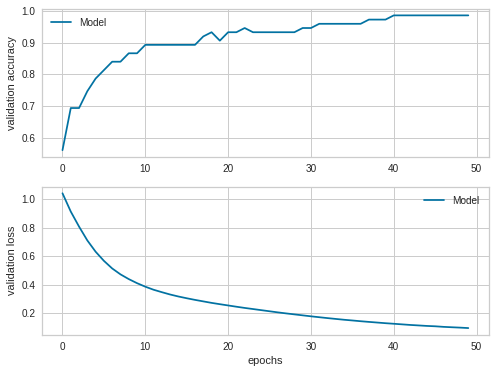

In [40]:
# Plot accuracy
fig, (ax1, ax2) = plt.subplots(2, figsize=(8, 6))

val_acc = history_callback.history['val_acc']
val_loss = history_callback.history['val_loss']
ax1.plot(val_acc, label="Model")
ax2.plot(val_loss, label="Model")
    
ax1.set_ylabel('validation accuracy')
ax2.set_ylabel('validation loss')
ax2.set_xlabel('epochs')
ax1.legend()
ax2.legend()
plt.show()

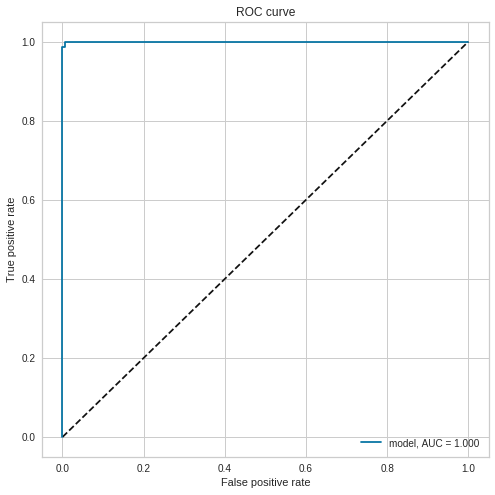

In [41]:
# Plot ROC
plt.figure(figsize=(8, 8))
plt.plot([0, 1], [0, 1], 'k--')
    
Y_pred = model.predict(X_test)
fpr, tpr, threshold = roc_curve(Y_test.ravel(), Y_pred.ravel())

plt.plot(fpr, tpr, label='{}, AUC = {:.3f}'.format("model", auc(fpr, tpr)))
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC curve')
plt.legend();

In [26]:
# Function to output innvestigate's LRP Alphabeta value:  
def deeptaylor (instance, dataframe):
    # Stripping the softmax activation from the model
    model_wo_sm = iutils.keras.graph.model_wo_softmax(model)

    # Creating an analyzer
#     gradient_analyzer = innvestigate.create_analyzer("lrp.alpha_2_beta_1", model_wo_sm)
    gradient_analyzer = innvestigate.create_analyzer("deep_taylor", model_wo_sm)

    # Applying the analyzer (reshape the instance for the LRP function)
    analysis = gradient_analyzer.analyze(np.expand_dims(dataframe[instance], axis=0))
    lst = []
    x = np.reshape (analysis,(4,))
    for i in range (len(x)):
      lst.append(x[i])
    return lst

In [27]:
# Choose an instance to test:
example = 74
example = X_train[example]

model_wo_sm = iutils.keras.graph.model_wo_softmax(model)

# Creating an analyzer
gradient_analyzer = innvestigate.create_analyzer("deep_taylor", model_wo_sm)

# Applying the analyzer
analysis = gradient_analyzer.analyze(np.expand_dims(example, axis=0))

print (analysis)

[[[[0.45790088]
   [0.04924607]]

  [[1.1559111 ]
   [1.3890791 ]]]]


In [28]:
# Create and save two dataframes (train and test) containing Alphabeta LRP information obtained from the 2D CNN:

df = pd.DataFrame(columns=list(iris.feature_names))
for i in range(len(X_train)):
  df.loc[i] = deeptaylor(i, X_train)

lst = []
for i in Y_train:
  lst.append (i.argmax(axis = 0))
lst = pd.Series (lst)
df['target'] =  lst

# df1 = pd.DataFrame(columns=list(iris.feature_names))
# for i in range(len(X_test)):
#   df1.loc[i] = alphabeta(i,X_test)

# lst1 = []
# for i in Y_test:
#   lst1.append (i.argmax(axis = 0))
# lst1 = pd.Series (lst1)
# df1['target'] =  lst1

df.to_pickle("iris_x_train_deep_taylor_relevance_pickle.pkl")
# df1.to_pickle("iris_y_relevance_pickle.pkl")

# from google.colab import files
# files.download('iris_x_relevance_pickle.pkl')
# files.download('iris_y_relevance_pickle.pkl')

In [3]:
# train = pd.read_pickle ('/content/gdrive/My Drive/Studie/Notebooks/LRP/iris_x_relevance_pickle.pkl')
deep_taylor_train = pd.read_pickle ('/home/shayan/Desktop/code/lrp/lrp/code/iris_x_train_deep_taylor_relevance_pickle.pkl')
# test = pd.read_pickle ('/content/gdrive/My Drive/Studie/Notebooks/LRP/iris_y_relevance_pickle.pkl')
# test = pd.read_pickle ('/home/shayan/Desktop/code/lrp/lrp/code/iris_y_relevance_pickle.pkl')

In [4]:
# lrp_data = pd.concat ([train,test], axis = 0)
deep_taylor_train.head()

,sepal length (cm),sepal width (cm),petal length (cm),petal width (cm),target
0,0.031933,0.023102,0.022295,0.007597,1
1,0.090450,0.038161,0.616697,1.181441,2
2,0.047380,0.592052,0.013931,0.004873,1
3,0.350396,1.378289,0.850817,0.837465,0
4,0.067504,0.343413,0.024432,0.028592,1


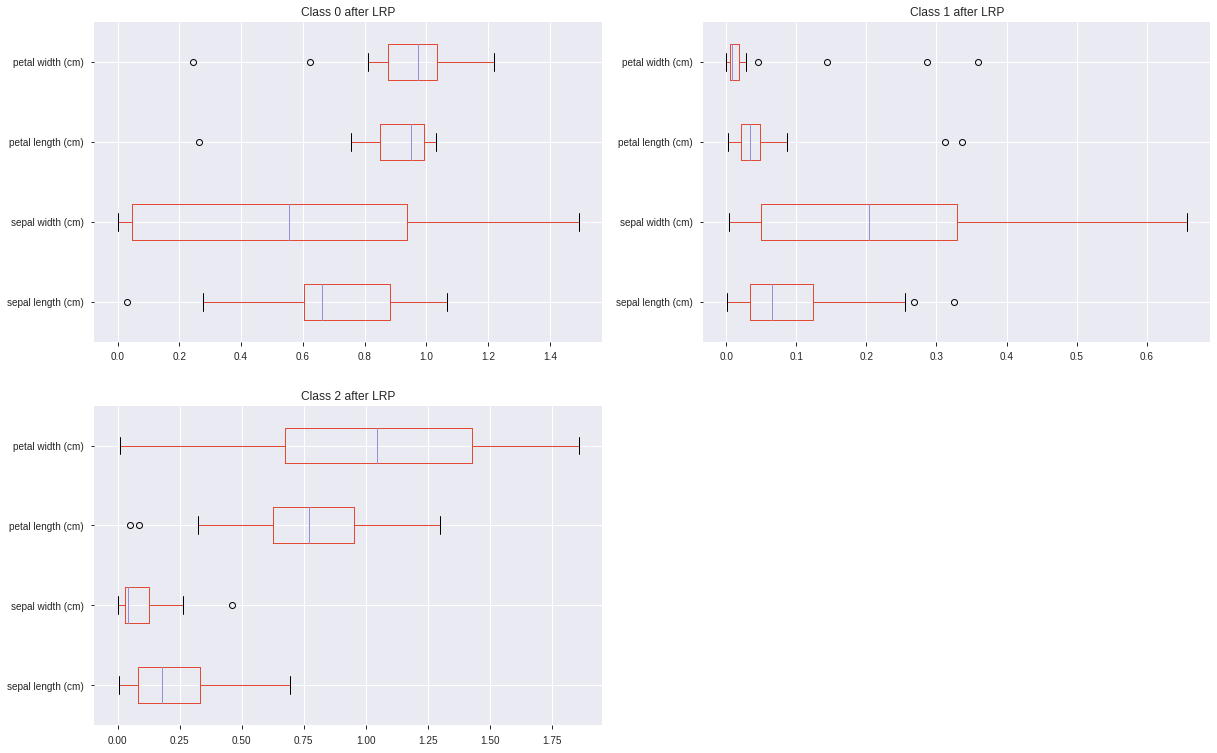

(75, 5)


In [5]:
# To plot the distribution of the deep_taylor dataset:
df = deep_taylor_train

fig = plt.figure() # create figure

ax0 = fig.add_subplot(3, 2, 1) # add subplot 1 (3 row, 2 columns, first plot)
ax1 = fig.add_subplot(322) # add subplot 2 (3 row, 2 columns, second plot). See tip below**
ax2 = fig.add_subplot(323) # add subplot 3 (3 row, 2 columns, third plot). See tip below**


# Subplot 1: Box plot
df0 = df[df['target'] == 0]
df0 = df0.drop ('target', axis= 1)
df0.plot(
             kind = 'box',
             vert = False, 
#              kind = 'area',
#              alpha = .25,
             stacked=False,
             figsize=(20, 20),
             ax=ax0) # add to subplot 1
ax0.set_title('Class 0 after LRP')
# ax0.set_xlabel('X')
# ax0.set_ylabel('Y')

# # Subplot 2: Box plot
df1 = df[df['target'] == 1]
df1 = df1.drop ('target', axis= 1)
df1.plot(
             kind = 'box',
             vert = False, 
#              kind = 'area',
#              alpha = .25,
             stacked=False,
             figsize=(20, 20),
             ax=ax1) # add to subplot 1
ax1.set_title('Class 1 after LRP')
# ax1.set_xlabel('X')
# ax1.set_ylabel('Y')


# # Subplot 3: Box plot
df2 = df[df['target'] == 2]
df2 = df2.drop ('target', axis= 1)
df2.plot(
             kind = 'box',
             vert = False, 
#              kind = 'area',
#              alpha = .25,
             stacked=False,
             figsize=(20, 20),
             ax=ax2) # add to subplot 1
ax2.set_title('Class 2 after LRP')
# ax1.set_xlabel('X')
# ax1.set_ylabel('Y')

plt.show()
print (df.shape)

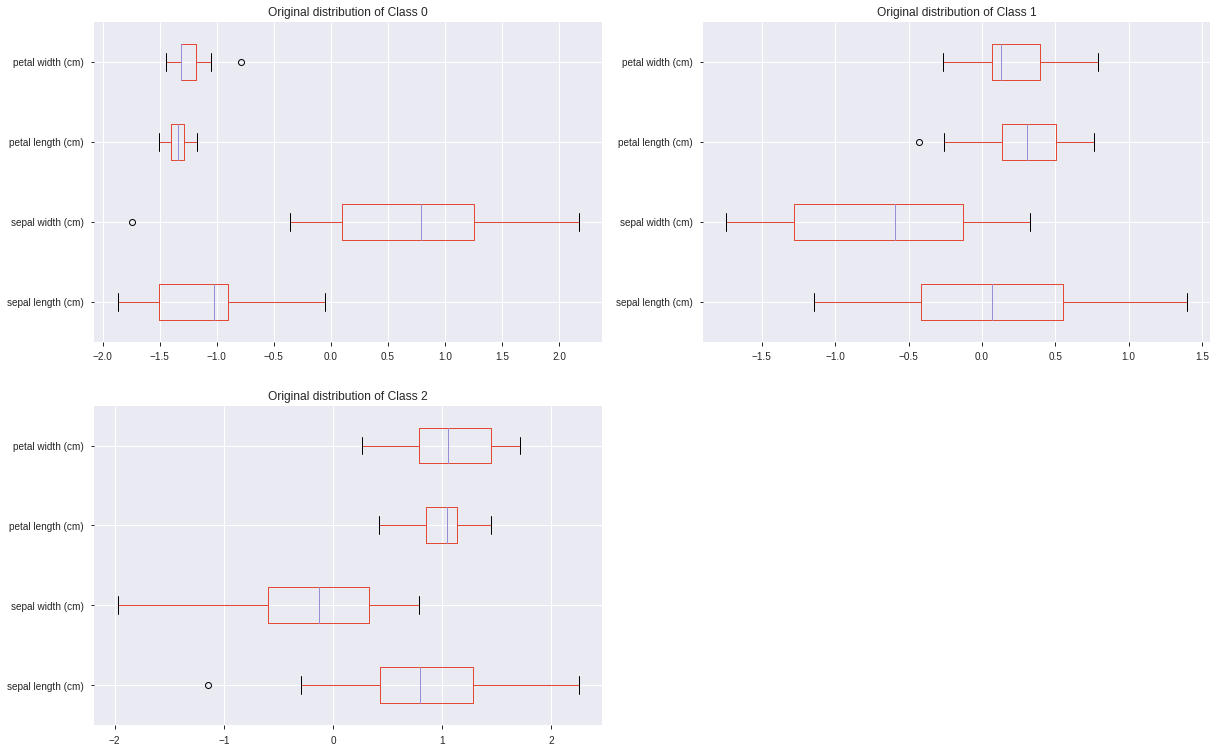

(75, 5)


In [6]:
# To plot the distibution of the original Iris dataset
iris = load_iris()
X = iris['data']
y = iris['target']
names = iris['target_names']
feature_names = iris['feature_names']

# Scale data to have mean 0 and variance 1 
# which is importance for convergence of the neural network
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Split the data set into training and testing
X_train, X_test, Y_train, Y_test = train_test_split(
    X_scaled, y, test_size=0.5, random_state=42)

train_df = pd.DataFrame(X_train, columns=list(iris.feature_names))
train_df['target'] =  Y_train

# test_df = pd.DataFrame(X_test, columns=list(iris.feature_names))
# test_df['target'] =  Y_test

# df = pd.concat ([train_df, test_df], axis = 0)

df = train_df
original_data = df

fig = plt.figure() # create figure

ax0 = fig.add_subplot(3, 2, 1) # add subplot 1 (3 row, 2 columns, first plot)
ax1 = fig.add_subplot(322) # add subplot 2 (3 row, 2 columns, second plot). See tip below**
ax2 = fig.add_subplot(323) # add subplot 3 (3 row, 2 columns, thirs plot). See tip below**


# Subplot 1: Box plot
df0 = df[df['target'] == 0]
df0 = df0.drop ('target', axis= 1)
df0.plot(
             kind = 'box',
             vert = False, 
#              kind = 'area',
#              alpha = .25,
             stacked=False,
             figsize=(20, 20),
             ax=ax0) # add to subplot 1
ax0.set_title('Original distribution of Class 0')
# ax0.set_xlabel('X')
# ax0.set_ylabel('Y')

# # Subplot 2: Box plot
df1 = df[df['target'] == 1]
df1 = df1.drop ('target', axis= 1)
df1.plot(
             kind = 'box',
             vert = False, 
#              kind = 'area',
#              alpha = .25,
             stacked=False,
             figsize=(20, 20),
             ax=ax1) # add to subplot 1
ax1.set_title('Original distribution of Class 1')
# ax1.set_xlabel('X')
# ax1.set_ylabel('Y')


# # Subplot 3: Box plot
df2 = df[df['target'] == 2]
df2 = df2.drop ('target', axis= 1)
df2.plot(
             kind = 'box',
             vert = False, 
#              kind = 'area',
#              alpha = .25,
             stacked=False,
             figsize=(20, 20),
             ax=ax2) # add to subplot 1
ax2.set_title('Original distribution of Class 2')
# ax1.set_xlabel('X')
# ax1.set_ylabel('Y')

plt.show()
print(df.shape)


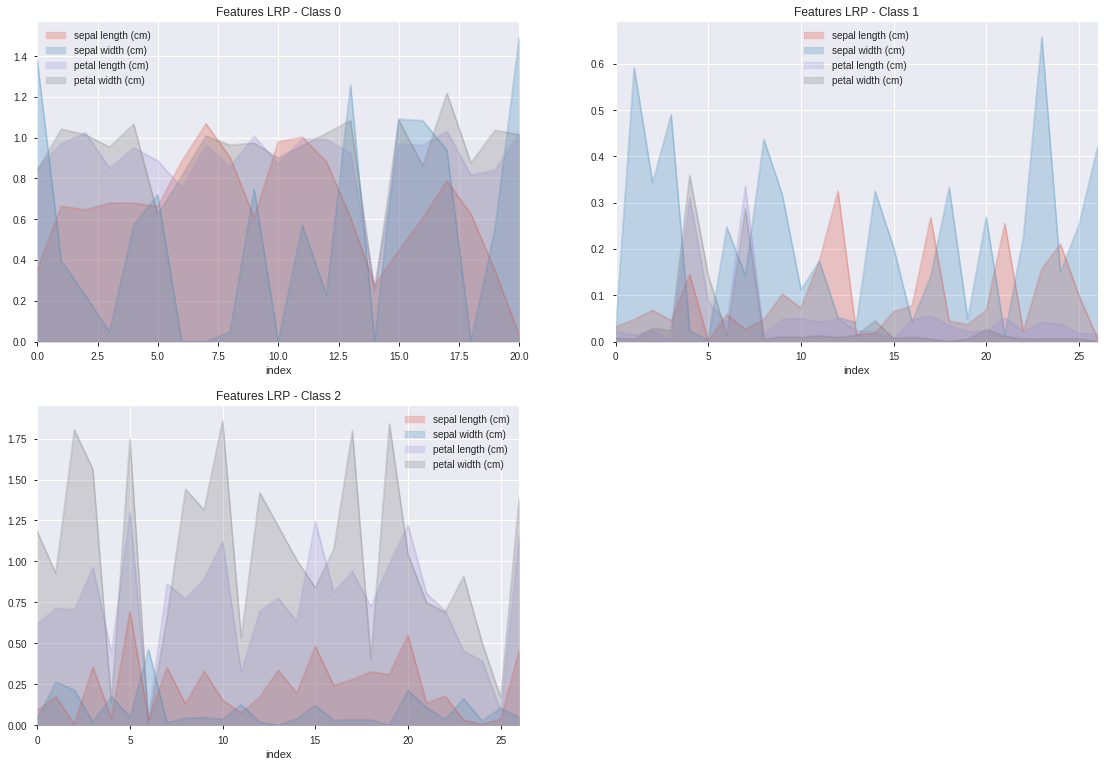

In [7]:
# Visualize area plot for the Deep Taylor dataset
df = deep_taylor_train

fig = plt.figure() # create figure

ax0 = fig.add_subplot(3, 2, 1) # add subplot 1 (3 row, 2 columns, first plot)
ax1 = fig.add_subplot(322) 
ax2 = fig.add_subplot(323)

# Subplot 1: Are plot
df0 = df[df['target'] == 0]
df0 = df0.drop ('target', axis= 1)
df0['index'] = range(0, df0.shape[0])

df0.plot(x = 'index',
#              kind = 'box',
#              vert = False, 
             kind = 'area',
             alpha = .25,
             stacked=False,
             figsize=(19, 20),
             ax=ax0) # add to subplot 1
ax0.set_title('Features LRP - Class 0')
# ax0.set_xlabel('X')
# ax0.set_ylabel('Y')

# # Subplot 2: Are plot
df1 = df[df['target'] == 1]
df1 = df1.drop ('target', axis= 1)
df1['index'] = range(0, df1.shape[0])


df1.plot(x = 'index',
#              kind = 'box',
#              vert = False, 
             kind = 'area',
             alpha = .25,
             stacked=False,
             figsize=(19, 20),
             ax=ax1) # add to subplot 1
ax1.set_title('Features LRP - Class 1')
# ax1.set_xlabel('X')
# ax1.set_ylabel('Y')


# # Subplot 3: Are plot
df2 = df[df['target'] == 2]
df2 = df2.drop ('target', axis= 1)
df2['index'] = range(0, df2.shape[0])
df2.plot(x = 'index',
#              kind = 'box',
#              vert = False, 
             kind = 'area',
             alpha = .25,
             stacked=False,
             figsize=(19, 20),
             ax=ax2) # add to subplot 1
ax2.set_title('Features LRP - Class 2')
# ax1.set_xlabel('X')
# ax1.set_ylabel('Y')

plt.show()

# Clutering

## K-Means Clustering of the whole LRP Dataset

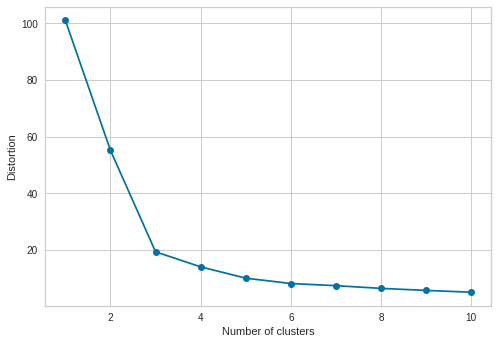

In [39]:
from sklearn.cluster import KMeans
# calculate distortion to find the optimal number of clusters (elbow method)
distortions = []
for i in range(1, 11):
    km = KMeans(
        n_clusters=i, init='random',
        n_init=10, max_iter=300,
        tol=1e-04, random_state=0
    )
    km.fit(deep_taylor_train)
    distortions.append(km.inertia_)

# plot
plt.plot(range(1, 11), distortions, marker='o')
plt.xlabel('Number of clusters')
plt.ylabel('Distortion')
plt.show()

In [40]:
data = deep_taylor_train.drop ('target', axis = 1)
km = KMeans(
    n_clusters=3, init='random',
    n_init=10, max_iter=300, 
    tol=1e-04, random_state=0
)
y_km = km.fit_predict(data)

In [41]:
# deep_taylor_train dataset plus clusters
clustered_data = data
clustered_data['cluster'] = y_km
clustered_data.head()

,sepal length (cm),sepal width (cm),petal length (cm),petal width (cm),cluster
0,0.031933,0.023102,0.022295,0.007597,0
1,0.090450,0.038161,0.616697,1.181441,2
2,0.047380,0.592052,0.013931,0.004873,0
3,0.350396,1.378289,0.850817,0.837465,1
4,0.067504,0.343413,0.024432,0.028592,0


In [42]:
# Original dataset with clusters added
original_data['cluster'] = clustered_data['cluster']
original_data.head(15)

,sepal length (cm),sepal width (cm),petal length (cm),petal width (cm),target,cluster
0,-0.537178,-0.131979,0.421734,0.395774,1,0
1,0.432165,0.788808,0.933271,1.448832,2,2
2,-0.416010,-1.743357,0.137547,0.132510,1,0
3,-0.537178,1.939791,-1.169714,-1.052180,0,1
4,-1.021849,-1.743357,-0.260315,-0.262387,1,0
5,0.674501,-0.822570,0.876433,0.922303,2,2
6,-1.021849,0.558611,-1.340227,-1.315444,0,2
7,-1.021849,0.328414,-1.453901,-1.315444,0,2
8,-0.416010,-1.513160,0.023872,-0.130755,1,0
9,1.038005,-0.131979,0.705921,0.659038,1,0


In [43]:
# Ignore this.
import matplotlib.cm
x = sorted(list(matplotlib.cm.cmap_d.keys()))
counter = 0
while counter < len (x):
  print (x[counter: counter + 6])
  counter = counter + 6

['Accent', 'Accent_r', 'Blues', 'Blues_r', 'BrBG', 'BrBG_r']
['BuGn', 'BuGn_r', 'BuPu', 'BuPu_r', 'CMRmap', 'CMRmap_r']
['Dark2', 'Dark2_r', 'GnBu', 'GnBu_r', 'Greens', 'Greens_r']
['Greys', 'Greys_r', 'OrRd', 'OrRd_r', 'Oranges', 'Oranges_r']
['PRGn', 'PRGn_r', 'Paired', 'Paired_r', 'Pastel1', 'Pastel1_r']
['Pastel2', 'Pastel2_r', 'PiYG', 'PiYG_r', 'PuBu', 'PuBuGn']
['PuBuGn_r', 'PuBu_r', 'PuOr', 'PuOr_r', 'PuRd', 'PuRd_r']
['Purples', 'Purples_r', 'RdBu', 'RdBu_r', 'RdGy', 'RdGy_r']
['RdPu', 'RdPu_r', 'RdYlBu', 'RdYlBu_r', 'RdYlGn', 'RdYlGn_r']
['Reds', 'Reds_r', 'Set1', 'Set1_r', 'Set2', 'Set2_r']
['Set3', 'Set3_r', 'Spectral', 'Spectral_r', 'Wistia', 'Wistia_r']
['YlGn', 'YlGnBu', 'YlGnBu_r', 'YlGn_r', 'YlOrBr', 'YlOrBr_r']
['YlOrRd', 'YlOrRd_r', 'afmhot', 'afmhot_r', 'autumn', 'autumn_r']
['binary', 'binary_r', 'bone', 'bone_r', 'brg', 'brg_r']
['bwr', 'bwr_r', 'cividis', 'cividis_r', 'cool', 'cool_r']
['coolwarm', 'coolwarm_r', 'copper', 'copper_r', 'cubehelix', 'cubehelix_r']
['

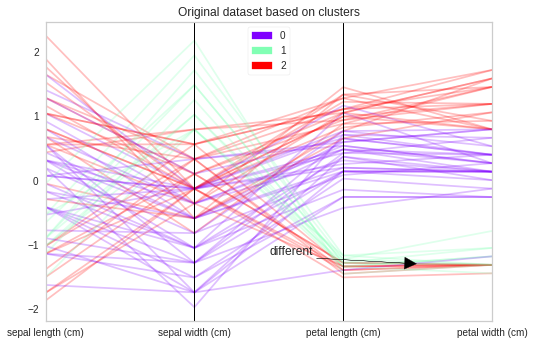

In [59]:
# Visualize the original dataset based on the three clusters
from yellowbrick.features import ParallelCoordinates

# Load the classification data set
data = original_data

# Instantiate the visualizer
visualizer = ParallelCoordinates(colormap='rainbow', title = 'Original dataset based on clusters')

# Extract the instances and target
X = data[list(iris.feature_names)]
y = data['cluster']

# Fit the visualizer and display it
visualizer.fit_transform(X, y)
plt.annotate('different', xy=(2.5, -1.3),  xycoords='data',
            xytext=(0.6, 0.25), textcoords='axes fraction',
            arrowprops=dict(shrink=0.01, width=.01, color='black'),
            horizontalalignment='right', verticalalignment='top',
            )


visualizer.poof()

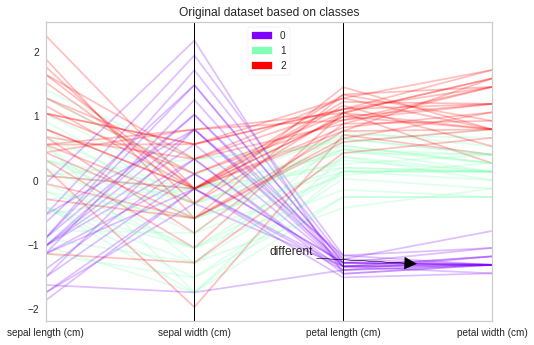

In [4]:
# Visualize the original dataset based on the three targets
from yellowbrick.features import ParallelCoordinates

# Load the classification data set
data = original_data

# Instantiate the visualizer
visualizer = ParallelCoordinates(colormap='rainbow', title = 'Original dataset based on classes')

# Extract the instances and target
X = data[list(iris.feature_names)]
y = data['target']

# Fit the visualizer and display it
visualizer.fit_transform(X, y)
plt.annotate('different', xy=(2.5, -1.3),  xycoords='data',
            xytext=(0.6, 0.25), textcoords='axes fraction',
            arrowprops=dict(shrink=0.01, width=.01, color='black'),
            horizontalalignment='right', verticalalignment='top',
            )


visualizer.poof()

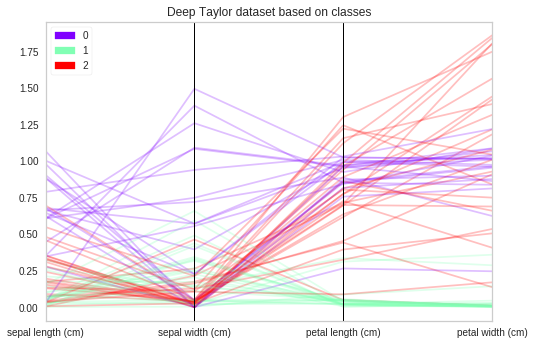

In [8]:
# Visualize the deep taylor dataset based on the classes using parallel coordinates
from yellowbrick.features import ParallelCoordinates

# Load the classification data set
data = deep_taylor_train

# Instantiate the visualizer
visualizer = ParallelCoordinates(colormap='rainbow', title = 'Deep Taylor dataset based on classes')

# Extract the instances and target
X = data[list(iris.feature_names)]
y = data['target']

# Fit the visualizer and display it
visualizer.fit_transform(X, y)

visualizer.poof()

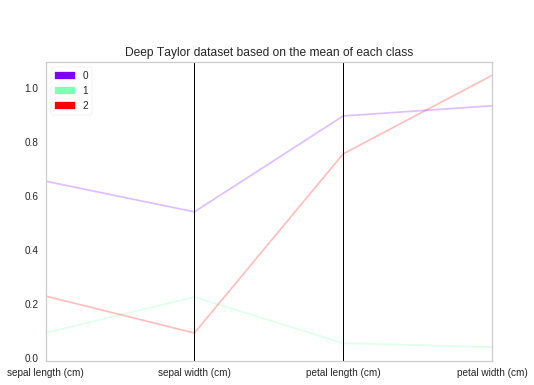

,sepal length (cm),sepal width (cm),petal length (cm),petal width (cm)
target,,,,
0,0.653987,0.540480,0.895608,0.933336
1,0.092237,0.225068,0.053961,0.039221
2,0.228560,0.091767,0.755362,1.045798


{0: {'sepal length (cm)': 0.6539868307965142,
  'sepal width (cm)': 0.5404802299013854,
  'petal length (cm)': 0.8956079326924824,
  'petal width (cm)': 0.9333362245843524},
 1: {'sepal length (cm)': 0.09223708582403897,
  'sepal width (cm)': 0.22506844812003826,
  'petal length (cm)': 0.05396079338431634,
  'petal width (cm)': 0.03922093492689816},
 2: {'sepal length (cm)': 0.2285599278424073,
  'sepal width (cm)': 0.09176682805021603,
  'petal length (cm)': 0.75536232414069,
  'petal width (cm)': 1.0457982492322724}}

In [8]:
# Visualize the deep taylor dataset based on the mean for each class using parallel coordinates

deep_taylor_mean = deep_taylor_train.groupby(['target']).mean()

from yellowbrick.features import ParallelCoordinates

# Instantiate the visualizer
visualizer = ParallelCoordinates(colormap='rainbow', title = 'Deep Taylor dataset based on the mean of each class')

# Extract the instances and target
X = deep_taylor_mean[list(iris.feature_names)]
y = [0,1,2]

# Fit the visualizer and display it
visualizer.fit_transform(X, y)
plt.annotate('different', xy=(2.85, 1.3),  xycoords='data',
            xytext=(0.6, 0.95), textcoords='axes fraction',
            arrowprops=dict(shrink=0.01, width=.01, color='black'),
            horizontalalignment='right', verticalalignment='top',
            )


visualizer.poof()

display (deep_taylor_mean)

deep_taylor_means = deep_taylor_mean.T.to_dict()
display (deep_taylor_means)

In [9]:
# display(original_data.head())
# import seaborn as sns; sns.set(color_codes=True)
# ax = sns.kdeplot(original_data['sepal length (cm)'])

In [10]:
# Ignore this.
# original_data.profile_report(style={'full_width':True})

In [17]:
original_mean = original_data.groupby(['target']).mean()
# print (original_mean.iat[2,3])
display (original_mean)
means = original_mean.T.to_dict()
display (means)

,sepal length (cm),sepal width (cm),petal length (cm),petal width (cm)
target,,,,
0,-1.114167,0.635343,-1.326694,-1.259031
1,0.064174,-0.728786,0.278588,0.186138
2,0.818108,-0.174609,0.994318,1.083187


{0: {'sepal length (cm)': -1.1141674182223378,
  'sepal width (cm)': 0.6353430748738624,
  'petal length (cm)': -1.326693805929049,
  'petal width (cm)': -1.2590305017404688},
 1: {'sepal length (cm)': 0.06417409434608047,
  'sepal width (cm)': -0.7287859103625609,
  'petal length (cm)': 0.2785875954720814,
  'petal width (cm)': 0.18613765911865418},
 2: {'sepal length (cm)': 0.8181075104399107,
  'sepal width (cm)': -0.17460851011026401,
  'petal length (cm)': 0.9943181566063435,
  'petal width (cm)': 1.0831866187266304}}

In [18]:
test = original_data.copy()
# test['new'] = (test.iloc[:,0]+100)**2
test.head()

,sepal length (cm),sepal width (cm),petal length (cm),petal width (cm),target
0,-0.537178,-0.131979,0.421734,0.395774,1
1,0.432165,0.788808,0.933271,1.448832,2
2,-0.416010,-1.743357,0.137547,0.132510,1
3,-0.537178,1.939791,-1.169714,-1.052180,0
4,-1.021849,-1.743357,-0.260315,-0.262387,1


In [19]:
# This cell calculates the squared distance of each attribute from the mean of such attribute for each class. Then
# it multiplies it with the mean of the LRP of that class from the deep taylor dataset.
def calc_distance(df):
    original_mean = df.groupby(['target']).mean()
    means = original_mean.T.to_dict()
    clusters = sorted(df[df.columns.values[-1]].unique())
    columns = df.columns.values[:-1]
    for cluster in clusters:
        for column in columns:
            new_column = column + '_sqrd_distance_from_mean_times_LRP_mean_class_' + str(cluster)
            df[new_column] = ((df[column]- means[cluster][column])**2)*deep_taylor_means[cluster][column]

In [20]:
calc_distance(test)
test.head()

,sepal length (cm),sepal width (cm),petal length (cm),petal width (cm),target,sepal length (cm)_sqrd_distance_from_mean_times_LRP_mean_class_0,sepal width (cm)_sqrd_distance_from_mean_times_LRP_mean_class_0,petal length (cm)_sqrd_distance_from_mean_times_LRP_mean_class_0,petal width (cm)_sqrd_distance_from_mean_times_LRP_mean_class_0,sepal length (cm)_sqrd_distance_from_mean_times_LRP_mean_class_1,sepal width (cm)_sqrd_distance_from_mean_times_LRP_mean_class_1,petal length (cm)_sqrd_distance_from_mean_times_LRP_mean_class_1,petal width (cm)_sqrd_distance_from_mean_times_LRP_mean_class_1,sepal length (cm)_sqrd_distance_from_mean_times_LRP_mean_class_2,sepal width (cm)_sqrd_distance_from_mean_times_LRP_mean_class_2,petal length (cm)_sqrd_distance_from_mean_times_LRP_mean_class_2,petal width (cm)_sqrd_distance_from_mean_times_LRP_mean_class_2
0,-0.537178,-0.131979,0.421734,0.395774,1,0.217724,0.318226,2.737872,2.555828,0.033355,0.080164,0.001106,0.001724,0.419818,0.000167,0.247648,0.494177
1,0.432165,0.788808,0.933271,1.448832,2,1.563777,0.012729,4.574263,6.843704,0.012491,0.518353,0.023128,0.062534,0.034044,0.085175,0.002815,0.139819
2,-0.416010,-1.743357,0.137547,0.132510,1,0.318769,3.058152,1.920183,1.807298,0.021268,0.231675,0.001073,0.000113,0.348107,0.225836,0.554479,0.945178
3,-0.537178,1.939791,-1.169714,-1.052180,0,0.217724,0.919673,0.022070,0.039935,0.033355,1.602781,0.113187,0.060143,0.419818,0.410261,3.537389,4.768621
4,-1.021849,-1.743357,-0.260315,-0.262387,1,0.005574,3.058152,1.018452,0.927082,0.108789,0.231675,0.015671,0.007890,0.773776,0.225836,1.189020,1.893489


In [21]:
# To test the result of the above cell on an instance: 
instance = 34
display (test.iloc[instance,:])

display(means[1])
display(deep_taylor_means[1])

assert (round(((0.535409 -(0.2785875954720814))**2)*0.05396079338431634, 6) ==  0.003559)

sepal length (cm)                                                   0.310998
sepal width (cm)                                                   -0.362176
petal length (cm)                                                   0.535409
petal width (cm)                                                    0.264142
target                                                              1.000000
sepal length (cm)_sqrd_distance_from_mean_times_LRP_mean_class_0    1.328309
sepal width (cm)_sqrd_distance_from_mean_times_LRP_mean_class_0     0.537802
petal length (cm)_sqrd_distance_from_mean_times_LRP_mean_class_0    3.105454
petal width (cm)_sqrd_distance_from_mean_times_LRP_mean_class_0     2.165391
sepal length (cm)_sqrd_distance_from_mean_times_LRP_mean_class_1    0.005619
sepal width (cm)_sqrd_distance_from_mean_times_LRP_mean_class_1     0.030250
petal length (cm)_sqrd_distance_from_mean_times_LRP_mean_class_1    0.003559
petal width (cm)_sqrd_distance_from_mean_times_LRP_mean_class_1     0.000239

{'sepal length (cm)': 0.06417409434608047,
 'sepal width (cm)': -0.7287859103625609,
 'petal length (cm)': 0.2785875954720814,
 'petal width (cm)': 0.18613765911865418}

{'sepal length (cm)': 0.09223708582403897,
 'sepal width (cm)': 0.22506844812003826,
 'petal length (cm)': 0.05396079338431634,
 'petal width (cm)': 0.03922093492689816}

In [22]:
# This cell sums the distance of all the attributes for each class.
def calc_weighted(df):
    targets = sorted(df['target'].unique())
    columns = df.columns.values[-12:]

    for target in targets:
        lst = list()
        for column in columns:
            if column[-1] == str(target):
                lst.append(column)
        new_column = 'class_' + str(target) + '_sum'
        df[new_column] = df[lst].sum(axis=1)

In [23]:
calc_weighted(test)
test.head()

,sepal length (cm),sepal width (cm),petal length (cm),petal width (cm),target,sepal length (cm)_sqrd_distance_from_mean_times_LRP_mean_class_0,sepal width (cm)_sqrd_distance_from_mean_times_LRP_mean_class_0,petal length (cm)_sqrd_distance_from_mean_times_LRP_mean_class_0,petal width (cm)_sqrd_distance_from_mean_times_LRP_mean_class_0,sepal length (cm)_sqrd_distance_from_mean_times_LRP_mean_class_1,sepal width (cm)_sqrd_distance_from_mean_times_LRP_mean_class_1,petal length (cm)_sqrd_distance_from_mean_times_LRP_mean_class_1,petal width (cm)_sqrd_distance_from_mean_times_LRP_mean_class_1,sepal length (cm)_sqrd_distance_from_mean_times_LRP_mean_class_2,sepal width (cm)_sqrd_distance_from_mean_times_LRP_mean_class_2,petal length (cm)_sqrd_distance_from_mean_times_LRP_mean_class_2,petal width (cm)_sqrd_distance_from_mean_times_LRP_mean_class_2,class_0_sum,class_1_sum,class_2_sum
0,-0.537178,-0.131979,0.421734,0.395774,1,0.217724,0.318226,2.737872,2.555828,0.033355,0.080164,0.001106,0.001724,0.419818,0.000167,0.247648,0.494177,5.829650,0.116349,1.161810
1,0.432165,0.788808,0.933271,1.448832,2,1.563777,0.012729,4.574263,6.843704,0.012491,0.518353,0.023128,0.062534,0.034044,0.085175,0.002815,0.139819,12.994473,0.616505,0.261854
2,-0.416010,-1.743357,0.137547,0.132510,1,0.318769,3.058152,1.920183,1.807298,0.021268,0.231675,0.001073,0.000113,0.348107,0.225836,0.554479,0.945178,7.104402,0.254129,2.073600
3,-0.537178,1.939791,-1.169714,-1.052180,0,0.217724,0.919673,0.022070,0.039935,0.033355,1.602781,0.113187,0.060143,0.419818,0.410261,3.537389,4.768621,1.199402,1.809466,9.136089
4,-1.021849,-1.743357,-0.260315,-0.262387,1,0.005574,3.058152,1.018452,0.927082,0.108789,0.231675,0.015671,0.007890,0.773776,0.225836,1.189020,1.893489,5.009260,0.364025,4.082120


In [25]:
# To test the result of the above cell on an instance: 
instance = 34
display (test.iloc[instance,-15:])

assert (sum([1.328309,0.537802,3.105454,2.165391]) ==  7.136956)
assert (sum([0.005619,0.030250,0.003559,0.000239]) ==  0.039667)

sepal length (cm)_sqrd_distance_from_mean_times_LRP_mean_class_0    1.328309
sepal width (cm)_sqrd_distance_from_mean_times_LRP_mean_class_0     0.537802
petal length (cm)_sqrd_distance_from_mean_times_LRP_mean_class_0    3.105454
petal width (cm)_sqrd_distance_from_mean_times_LRP_mean_class_0     2.165391
sepal length (cm)_sqrd_distance_from_mean_times_LRP_mean_class_1    0.005619
sepal width (cm)_sqrd_distance_from_mean_times_LRP_mean_class_1     0.030250
petal length (cm)_sqrd_distance_from_mean_times_LRP_mean_class_1    0.003559
petal width (cm)_sqrd_distance_from_mean_times_LRP_mean_class_1     0.000239
sepal length (cm)_sqrd_distance_from_mean_times_LRP_mean_class_2    0.058777
sepal width (cm)_sqrd_distance_from_mean_times_LRP_mean_class_2     0.003229
petal length (cm)_sqrd_distance_from_mean_times_LRP_mean_class_2    0.159078
petal width (cm)_sqrd_distance_from_mean_times_LRP_mean_class_2     0.701557
class_0_sum                                                         7.136956

In [26]:
def find_min(df):
    min_class = min(df['class_0_sum'],df['class_1_sum'],df['class_2_sum'])
    if min_class == df['class_0_sum']:
        return 0
    elif min_class == df['class_1_sum']:
        return 1
    else:
        return 2

In [27]:
def predict(df):
    df['prediction'] = df.apply(lambda x : find_min(x), axis=1)

In [28]:
predict(test)
test.head()

,sepal length (cm),sepal width (cm),petal length (cm),petal width (cm),target,sepal length (cm)_sqrd_distance_from_mean_times_LRP_mean_class_0,sepal width (cm)_sqrd_distance_from_mean_times_LRP_mean_class_0,petal length (cm)_sqrd_distance_from_mean_times_LRP_mean_class_0,petal width (cm)_sqrd_distance_from_mean_times_LRP_mean_class_0,sepal length (cm)_sqrd_distance_from_mean_times_LRP_mean_class_1,...,petal length (cm)_sqrd_distance_from_mean_times_LRP_mean_class_1,petal width (cm)_sqrd_distance_from_mean_times_LRP_mean_class_1,sepal length (cm)_sqrd_distance_from_mean_times_LRP_mean_class_2,sepal width (cm)_sqrd_distance_from_mean_times_LRP_mean_class_2,petal length (cm)_sqrd_distance_from_mean_times_LRP_mean_class_2,petal width (cm)_sqrd_distance_from_mean_times_LRP_mean_class_2,class_0_sum,class_1_sum,class_2_sum,prediction
0,-0.537178,-0.131979,0.421734,0.395774,1,0.217724,0.318226,2.737872,2.555828,0.033355,...,0.001106,0.001724,0.419818,0.000167,0.247648,0.494177,5.829650,0.116349,1.161810,1
1,0.432165,0.788808,0.933271,1.448832,2,1.563777,0.012729,4.574263,6.843704,0.012491,...,0.023128,0.062534,0.034044,0.085175,0.002815,0.139819,12.994473,0.616505,0.261854,2
2,-0.416010,-1.743357,0.137547,0.132510,1,0.318769,3.058152,1.920183,1.807298,0.021268,...,0.001073,0.000113,0.348107,0.225836,0.554479,0.945178,7.104402,0.254129,2.073600,1
3,-0.537178,1.939791,-1.169714,-1.052180,0,0.217724,0.919673,0.022070,0.039935,0.033355,...,0.113187,0.060143,0.419818,0.410261,3.537389,4.768621,1.199402,1.809466,9.136089,0
4,-1.021849,-1.743357,-0.260315,-0.262387,1,0.005574,3.058152,1.018452,0.927082,0.108789,...,0.015671,0.007890,0.773776,0.225836,1.189020,1.893489,5.009260,0.364025,4.082120,1


In [29]:
# To create a confusion matrix for the original dataset's real targets and the targets we obtained above:
from sklearn.metrics import confusion_matrix
y_actu = test['target']
y_pred = test['prediction']
confusion = pd.crosstab(y_actu, y_pred)
confusion

prediction,0,1,2
target,,,
0,18,3,0
1,0,27,0
2,0,12,15


In [43]:
60/75

0.8

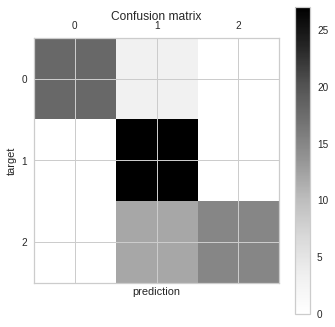

In [30]:
import matplotlib.pyplot as plt
def plot_confusion_matrix(df_confusion, title='Confusion matrix', cmap=plt.cm.Greys):
    plt.matshow(df_confusion, cmap=cmap) # imshow
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(df_confusion.columns))
#     plt.xticks(tick_marks, df_confusion.columns, rotation=45)
#     plt.yticks(tick_marks, df_confusion.index)
    plt.tight_layout()
    plt.ylabel(df_confusion.index.name)
    plt.xlabel(df_confusion.columns.name)

plot_confusion_matrix(confusion)

In [31]:
# import seaborn as sns; sns.set()
# ax = sns.heatmap(confusion)

# To test on the test data

In [32]:
# Load data
iris = load_iris()
X = iris['data']
y = iris['target']
names = iris['target_names']
feature_names = iris['feature_names']

# Scale data to have mean 0 and variance 1 
# which is importance for convergence of the neural network
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Split the data set into training and testing
X_train, X_test, Y_train, Y_test = train_test_split(
    X_scaled, y, test_size=0.5, random_state=42)

test_df = pd.DataFrame(X_test, columns=list(iris.feature_names))
test_df['target'] =  Y_test

# # To rearrange the the coloumns in order for them to be similar to the train dataset
# lst = test_df.columns.to_list()
# lst = lst[-1:] + lst [:-1]
# test_df = test_df[lst]

test_df.head()

,sepal length (cm),sepal width (cm),petal length (cm),petal width (cm),target
0,0.310998,-0.592373,0.535409,0.000878,1
1,-0.173674,1.709595,-1.169714,-1.183812,0
2,2.249683,-1.052767,1.785832,1.448832,2
3,0.189830,-0.362176,0.421734,0.395774,1
4,1.159173,-0.592373,0.592246,0.264142,1


In [33]:
# To test the result of the above cell on an instance: 
original_mean = test_df.groupby(['target']).mean()
display (original_mean)
means = original_mean.T.to_dict()
display (means)

,sepal length (cm),sepal width (cm),petal length (cm),petal width (cm)
target,,,,
0,-0.942463,1.011067,-1.289269,-1.251898
1,0.168757,-0.582364,0.293232,0.143956
2,1.001128,-0.212048,1.049417,1.093997


{0: {'sepal length (cm)': -0.9424631945887236,
  'sepal width (cm)': 1.011066532445446,
  'petal length (cm)': -1.2892688335278095,
  'petal width (cm)': -1.2518977232813888},
 1: {'sepal length (cm)': 0.16875699057441712,
  'sepal width (cm)': -0.5823644567841949,
  'petal length (cm)': 0.29323169902470053,
  'petal width (cm)': 0.14395600908037737},
 2: {'sepal length (cm)': 1.0011275788394998,
  'sepal width (cm)': -0.21204791975941578,
  'petal length (cm)': 1.0494165962230724,
  'petal width (cm)': 1.0939969913495053}}

In [34]:
calc_distance(test_df)
calc_weighted(test_df)
predict(test_df)
test_df.head()

,sepal length (cm),sepal width (cm),petal length (cm),petal width (cm),target,sepal length (cm)_sqrd_distance_from_mean_times_LRP_mean_class_0,sepal width (cm)_sqrd_distance_from_mean_times_LRP_mean_class_0,petal length (cm)_sqrd_distance_from_mean_times_LRP_mean_class_0,petal width (cm)_sqrd_distance_from_mean_times_LRP_mean_class_0,sepal length (cm)_sqrd_distance_from_mean_times_LRP_mean_class_1,...,petal length (cm)_sqrd_distance_from_mean_times_LRP_mean_class_1,petal width (cm)_sqrd_distance_from_mean_times_LRP_mean_class_1,sepal length (cm)_sqrd_distance_from_mean_times_LRP_mean_class_2,sepal width (cm)_sqrd_distance_from_mean_times_LRP_mean_class_2,petal length (cm)_sqrd_distance_from_mean_times_LRP_mean_class_2,petal width (cm)_sqrd_distance_from_mean_times_LRP_mean_class_2,class_0_sum,class_1_sum,class_2_sum,prediction
0,0.310998,-0.592373,0.535409,0.000878,1,1.027520,1.389585,2.981880,1.464821,0.001866,...,0.003165,0.000803,0.108858,0.013274,0.199570,1.249635,6.863805,0.005856,1.571337,1
1,-0.173674,1.709595,-1.169714,-1.183812,0,0.386530,0.263723,0.012801,0.004327,0.010816,...,0.115487,0.069145,0.315449,0.338868,3.719813,5.426035,0.667381,1.377750,9.800165,0
2,2.249683,-1.052767,1.785832,1.448832,2,6.663995,2.302125,8.469088,6.807697,0.399410,...,0.120217,0.066781,0.356300,0.064862,0.409639,0.131674,24.242906,0.636211,0.962474,1
3,0.189830,-0.362176,0.421734,0.395774,1,0.838468,1.019235,2.621919,2.533842,0.000041,...,0.000891,0.002487,0.150439,0.002068,0.297602,0.509843,7.013464,0.014331,0.959952,1
4,1.159173,-0.592373,0.592246,0.264142,1,2.888577,1.389585,3.170540,2.145158,0.090477,...,0.004825,0.000567,0.005709,0.013274,0.157874,0.720199,9.593859,0.095891,0.897056,1


In [35]:
# To test the result of the above cell on an instance: 
instance = 34
display (test_df.iloc[instance,:])

display(means[0])
display(deep_taylor_means[0])

assert (round(((-1.748856 -(-0.9424631945887236))**2)*0.6539868307965142, 6) ==  0.425268)

sepal length (cm)                                                   -1.748856
sepal width (cm)                                                     0.328414
petal length (cm)                                                   -1.397064
petal width (cm)                                                    -1.315444
target                                                               0.000000
sepal length (cm)_sqrd_distance_from_mean_times_LRP_mean_class_0     0.425268
sepal width (cm)_sqrd_distance_from_mean_times_LRP_mean_class_0      0.251872
petal length (cm)_sqrd_distance_from_mean_times_LRP_mean_class_0     0.010407
petal width (cm)_sqrd_distance_from_mean_times_LRP_mean_class_0      0.003769
sepal length (cm)_sqrd_distance_from_mean_times_LRP_mean_class_1     0.339178
sepal width (cm)_sqrd_distance_from_mean_times_LRP_mean_class_1      0.186698
petal length (cm)_sqrd_distance_from_mean_times_LRP_mean_class_1     0.154171
petal width (cm)_sqrd_distance_from_mean_times_LRP_mean_class_1 

{'sepal length (cm)': -0.9424631945887236,
 'sepal width (cm)': 1.011066532445446,
 'petal length (cm)': -1.2892688335278095,
 'petal width (cm)': -1.2518977232813888}

{'sepal length (cm)': 0.6539868307965142,
 'sepal width (cm)': 0.5404802299013854,
 'petal length (cm)': 0.8956079326924824,
 'petal width (cm)': 0.9333362245843524}

In [36]:
# To create a confusion matrix for the original dataset's real targets and the targets we obtained above:
from sklearn.metrics import confusion_matrix
y_actu = test_df['target']
y_pred = test_df['prediction']
confusion = pd.crosstab(y_actu, y_pred)
confusion

prediction,0,1,2
target,,,
0,24,5,0
1,0,23,0
2,0,11,12


In [42]:
59/75

0.7866666666666666

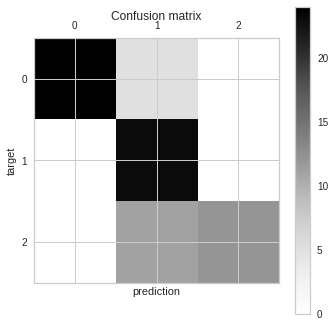

In [37]:
# To plot the confusion matrix
def plot_confusion_matrix(df_confusion, title='Confusion matrix', cmap=plt.cm.Greys):
    plt.matshow(df_confusion, cmap=cmap) # imshow
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(df_confusion.columns))
#     plt.xticks(tick_marks, df_confusion.columns, rotation=45)
#     plt.yticks(tick_marks, df_confusion.index)
    plt.tight_layout()
    plt.ylabel(df_confusion.index.name)
    plt.xlabel(df_confusion.columns.name)
    

plot_confusion_matrix(confusion)